# Load and Save Tensorflow Models

### Dependencies for Loading and Saving
https://www.tensorflow.org/tutorials/keras/save_and_load \
`pip install pyyaml h5py`  # Required to save models in HDF5 format

In [3]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import numpy as np

In [4]:
print(tf.version.VERSION)

2.8.0


### Load Data
https://www.tensorflow.org/datasets/catalog/goemotions

In [5]:
import tensorflow_datasets as tfds

In [7]:
data, info = tfds.load(
    "goemotions",
    with_info=True,
)

In [8]:
info

tfds.core.DatasetInfo(
    name='goemotions',
    full_name='goemotions/0.1.0',
    description="""
    The GoEmotions dataset contains 58k carefully curated Reddit comments labeled
    for 27 emotion categories or Neutral. The emotion categories are admiration,
    amusement, anger, annoyance, approval, caring, confusion, curiosity, desire,
    disappointment, disapproval, disgust, embarrassment, excitement, fear,
    gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief,
    remorse, sadness, surprise.
    """,
    homepage='https://github.com/google-research/google-research/tree/master/goemotions',
    data_path='/home/sam/tensorflow_datasets/goemotions/0.1.0',
    download_size=4.19 MiB,
    dataset_size=32.25 MiB,
    features=FeaturesDict({
        'admiration': tf.bool,
        'amusement': tf.bool,
        'anger': tf.bool,
        'annoyance': tf.bool,
        'approval': tf.bool,
        'caring': tf.bool,
        'comment_text': Text(shape=(), dtype=

In [9]:
emotions = dict(info.features)
emotions

{'comment_text': Text(shape=(), dtype=tf.string),
 'admiration': Tensor(shape=(), dtype=tf.bool),
 'amusement': Tensor(shape=(), dtype=tf.bool),
 'anger': Tensor(shape=(), dtype=tf.bool),
 'annoyance': Tensor(shape=(), dtype=tf.bool),
 'approval': Tensor(shape=(), dtype=tf.bool),
 'caring': Tensor(shape=(), dtype=tf.bool),
 'confusion': Tensor(shape=(), dtype=tf.bool),
 'curiosity': Tensor(shape=(), dtype=tf.bool),
 'desire': Tensor(shape=(), dtype=tf.bool),
 'disappointment': Tensor(shape=(), dtype=tf.bool),
 'disapproval': Tensor(shape=(), dtype=tf.bool),
 'disgust': Tensor(shape=(), dtype=tf.bool),
 'embarrassment': Tensor(shape=(), dtype=tf.bool),
 'excitement': Tensor(shape=(), dtype=tf.bool),
 'fear': Tensor(shape=(), dtype=tf.bool),
 'gratitude': Tensor(shape=(), dtype=tf.bool),
 'grief': Tensor(shape=(), dtype=tf.bool),
 'joy': Tensor(shape=(), dtype=tf.bool),
 'love': Tensor(shape=(), dtype=tf.bool),
 'nervousness': Tensor(shape=(), dtype=tf.bool),
 'optimism': Tensor(shape=()

In [10]:
emotions.pop("comment_text")

Text(shape=(), dtype=tf.string)

In [11]:
emotions

{'admiration': Tensor(shape=(), dtype=tf.bool),
 'amusement': Tensor(shape=(), dtype=tf.bool),
 'anger': Tensor(shape=(), dtype=tf.bool),
 'annoyance': Tensor(shape=(), dtype=tf.bool),
 'approval': Tensor(shape=(), dtype=tf.bool),
 'caring': Tensor(shape=(), dtype=tf.bool),
 'confusion': Tensor(shape=(), dtype=tf.bool),
 'curiosity': Tensor(shape=(), dtype=tf.bool),
 'desire': Tensor(shape=(), dtype=tf.bool),
 'disappointment': Tensor(shape=(), dtype=tf.bool),
 'disapproval': Tensor(shape=(), dtype=tf.bool),
 'disgust': Tensor(shape=(), dtype=tf.bool),
 'embarrassment': Tensor(shape=(), dtype=tf.bool),
 'excitement': Tensor(shape=(), dtype=tf.bool),
 'fear': Tensor(shape=(), dtype=tf.bool),
 'gratitude': Tensor(shape=(), dtype=tf.bool),
 'grief': Tensor(shape=(), dtype=tf.bool),
 'joy': Tensor(shape=(), dtype=tf.bool),
 'love': Tensor(shape=(), dtype=tf.bool),
 'nervousness': Tensor(shape=(), dtype=tf.bool),
 'optimism': Tensor(shape=(), dtype=tf.bool),
 'pride': Tensor(shape=(), dtype

In [68]:
data_train_original = data["train"]
data_valid_original = data["validation"]
data_test_original = data["test"]

#### Inspect the Dataset

In [42]:
print("train:", len(data_train_original))
print("valid:", len(data_valid_original))
print("test:", len(data_test_original))

train: 43410
valid: 5426
test: 5427


In [58]:
for comment in data_train_original.take(4):
    print(comment["comment_text"].numpy())
    [print(emotion,": ", comment[emotion].numpy()) for emotion in comment if (emotion!="comment_text") & (str(comment[emotion].numpy())=="True")]
    label = [float(comment[emotion]) for emotion in comment if emotion!="comment_text"]
    print(label)
                   

b"It's just wholesome content, from questionable sources"
neutral :  True
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
b'This is actually awesome.'
admiration :  True
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
b"People really spend more than $10 in an app game? I mean an actual video game I can understand but that's just...sad"
confusion :  True
sadness :  True
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
b'I grew up on the other side of Ama but live in Tulia now. I will have some El Burrito for you'
neutral :  True
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### Build Model

#### Helper Functions

##### Plot Model History

In [15]:
def render_history(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

##### Save Checkpoints During Training

In [16]:
checkpoint_path = "models/sandbox"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1
)


#### Set Hyperparameters

In [17]:
vocabulary_size = 10_000
sequence_length = 32
batch_size = 16
epochs = 10

#### Define Encoder

In [18]:
encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=sequence_length,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
)

In [19]:
encoder.adapt(data_train_original.map(lambda comment: comment["comment_text"]).batch(1024))

NameError: name 'data_train_original' is not defined

In [127]:
vocabulary = encoder.get_vocabulary()
print(encoder.vocabulary_size(), vocabulary[:50])

10000 ['', '[UNK]', 'the', 'i', 'to', 'a', 'you', 'and', 'is', 'that', 'name', 'it', 'of', 'this', 'in', 'for', 'was', 'my', 'not', 'but', 'be', 'on', 'so', 'just', 'have', 'are', 'like', 'with', 'me', 'they', 'your', 'he', 'what', 'its', 'if', 'as', 'im', 'at', 'all', 'about', 'no', 'do', 'love', 'one', 'get', 'people', 'we', 'would', 'good', 'dont']


In [128]:
data_train = data_train_original.map(lambda comment: (comment.pop("comment_text"), [float(comment[emotion]) for emotion in comment]))
data_train = data_train.cache()
data_train = data_train.shuffle(50_000)
data_train = data_train.batch(batch_size)

data_valid = data_valid_original.map(lambda comment: (comment.pop("comment_text"), [float(comment[emotion]) for emotion in comment]))
data_valid = data_valid.cache()
data_valid = data_valid.batch(batch_size)

In [129]:
for x, y in data_train.take(1):
    print(x)
    print(y)

tf.Tensor(
[b"Still wish [NAME] hadn't sent him away the way he did."
 b"Oh definitely. When you work for the gov't you root for the party looking to expand it. Maybe that's how you'll get a raise right?"
 b"What's worse is using self destruct without the pilot DLC. You just die :("
 b'link to the crack tweet?'
 b'Except that would retcon him trying to get her to have an abortion so still a mess'
 b'Too much time am running for it'
 b"Why don't Maroon 5? Regardless of the quality of the song, its been one of the most popular songs for the past 8 months"
 b'I wouldn\xe2\x80\x99t worry, most United fans have never even been to Manchester. '
 b'Oh my [NAME] I saw the rocks below the dog and feared the worst!'
 b'Damnit tobias.' b'Just to clarify, do you mean sidebar in game?'
 b'"You people"? I think [NAME] is a moron but I think the [NAME] hysteria is equally if not more so moronic.'
 b'What does IANAL mean? Thanks!'
 b'I can\xe2\x80\x99t translate /s to Texan speak well and forgot so my

#### Define Model

In [130]:
model = models.Sequential()
model.add(encoder)
model.add(layers.Dense(4, activation="relu"))
#model.add(layers.Dense(8, activation="sigmoid"))
model.add(layers.Dense(28, activation="softmax"))


model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_8 (TextV  (None, 32)               0         
 ectorization)                                                   
                                                                 
 dense_26 (Dense)            (None, 4)                 132       
                                                                 
 dense_27 (Dense)            (None, 28)                140       
                                                                 
Total params: 272
Trainable params: 272
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
2672/2714 [============================>.] - ETA: 0s - loss: 8.6285 - accuracy: 0.2383
Epoch 1: saving model to models/cp.cktp
2714/2714 [==============================] - 4s 1ms/step - loss: 8.5015 - accuracy: 0.2389 - val_loss: 0.2177 - val_accuracy: 0.2956
Epoch 2/10
2673/2714 [============================>.] - ETA: 0s - loss: 0.1866 - accuracy: 0.2859
Epoch 2: saving model to models/cp.cktp
2714/2714 [==============================] - 3s 1ms/step - loss: 0.1864 - accuracy: 0.2856 - val_loss: 0.1648 - val_accuracy: 0.2940
Epoch 3/10
2712/2714 [============================>.] - ETA: 0s - loss: 0.1611 - accuracy: 0.2877
Epoch 3: saving model to models/cp.cktp
2714/2714 [==============================] - 3s 1ms/step - loss: 0.1611 - accuracy: 0.2877 - val_loss: 0.1565 - val_accuracy: 0.2952
Epoch 4/10
2674/2714 [============================>.] - ETA: 0s - loss: 0.1521 - accuracy: 0.2964
Epoch 4: saving model to models/cp.cktp
2714/2714 [==============================] - 3s 1

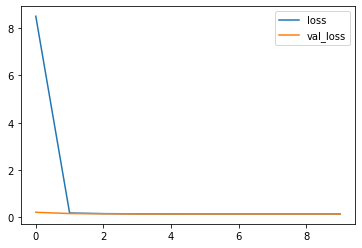

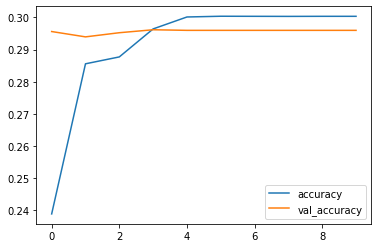

In [131]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    data_train,
    epochs=epochs,
    validation_data=data_valid,
    callbacks=[cp_callback]
)

render_history(history)

In [86]:
model.predict(["happy funny"])

array([[0.07806887, 0.04153374, 0.0272792 , 0.04448616, 0.05303967,
        0.01852004, 0.0233292 , 0.03926979, 0.0106782 , 0.02247746,
        0.03537749, 0.0134052 , 0.00534098, 0.01452378, 0.0102947 ,
        0.04672368, 0.0014353 , 0.02385209, 0.03806362, 0.00289347,
        0.3463369 , 0.02841275, 0.00192156, 0.01933908, 0.00259446,
        0.0092101 , 0.02268106, 0.01891149]], dtype=float32)

In [121]:
model2 = models.Sequential()
model2.add(encoder)
model2.add(layers.Dense(4, activation="relu"))
#model.add(layers.Dense(8, activation="sigmoid"))
model2.add(layers.Dense(28, activation="softmax"))



In [122]:
model2.load_weights(checkpoint_path)

Epoch 1/3
2687/2714 [============================>.] - ETA: 0s - loss: 0.1495 - accuracy: 0.3002
Epoch 1: saving model to models/cp.cktp
2714/2714 [==============================] - 4s 1ms/step - loss: 0.1495 - accuracy: 0.3003 - val_loss: 0.1493 - val_accuracy: 0.2960
Epoch 2/3
2695/2714 [============================>.] - ETA: 0s - loss: 0.1492 - accuracy: 0.3003
Epoch 2: saving model to models/cp.cktp
2714/2714 [==============================] - 3s 1ms/step - loss: 0.1492 - accuracy: 0.3003 - val_loss: 0.1493 - val_accuracy: 0.2960
Epoch 3/3
2698/2714 [============================>.] - ETA: 0s - loss: 0.1492 - accuracy: 0.3002
Epoch 3: saving model to models/cp.cktp
2714/2714 [==============================] - 3s 1ms/step - loss: 0.1492 - accuracy: 0.3003 - val_loss: 0.1492 - val_accuracy: 0.2960


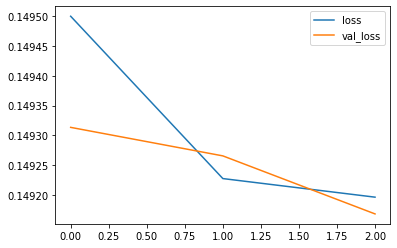

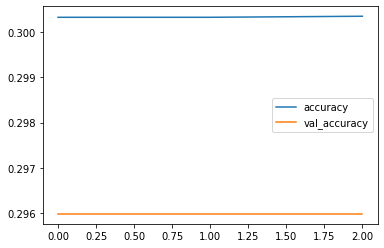

In [123]:
model2.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history2 = model2.fit(
    data_train,
    epochs=epochs,
    validation_data=data_valid,
    callbacks=[cp_callback]
)

render_history(history2)